# Simulate or load a realistic A/B dataset (website/product experiment)

In [3]:
# ab_experiment_analysis.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(42)

# Simulate 10,000 users
n = 10000
users = np.arange(1, n+1)

# Randomly assign users to groups (A = control, B = treatment)
groups = np.random.choice(['A', 'B'], size=n, p=[0.5, 0.5])

# Covariates
ages = np.random.normal(35, 8, size=n).astype(int)
devices = np.random.choice(['Desktop', 'Mobile', 'Tablet'], size=n, p=[0.6, 0.3, 0.1])
countries = np.random.choice(['US', 'UK', 'IN', 'DE', 'CA'], size=n, p=[0.4, 0.25, 0.15, 0.1, 0.1])

# Base conversion rates
base_rate = 0.08
treatment_effect = 0.012  # +1.2% lift
converted = np.random.binomial(1, base_rate + (groups == 'B') * treatment_effect, n)

# Build DataFrame
df = pd.DataFrame({
    'user_id': users,
    'group': groups,
    'converted': converted,
    'age': ages,
    'device': devices,
    'country': countries
})

df.head(10)


,user_id,group,converted,age,device,country
0,1,A,0,23,Desktop,US
1,2,B,0,25,Desktop,UK
2,3,B,0,38,Desktop,IN
3,4,B,0,25,Desktop,UK
4,5,A,0,43,Mobile,UK
5,6,A,0,34,Tablet,US
6,7,A,0,35,Mobile,UK
7,8,B,1,32,Tablet,CA
8,9,B,0,41,Mobile,US
9,10,B,0,41,Mobile,US


# Verify randomization & balance between groups

In [4]:
# Check group counts
print(df['group'].value_counts())

# Mean comparison for numeric covariate
print(df.groupby('group')['age'].mean())

# Crosstabs for categorical covariates
for col in ['device', 'country']:
    print(pd.crosstab(df[col], df['group'], normalize='index'))


group
A    5076
B    4924
Name: count, dtype: int64
group
A    34.685185
B    34.515435
Name: age, dtype: float64
group           A         B
device                     
Desktop  0.509990  0.490010
Mobile   0.506781  0.493219
Tablet   0.495366  0.504634
group           A         B
country                    
CA       0.497024  0.502976
DE       0.500509  0.499491
IN       0.521915  0.478085
UK       0.508387  0.491613
US       0.506216  0.493784


# Estimate the treatment effect (difference in conversion rates)

In [8]:
# Group-level summary
summary = df.groupby('group')['converted'].agg(['mean', 'count'])
summary['conversion_rate_%'] = summary['mean'] * 100
summary




,mean,count,conversion_rate_%
group,,,
A,0.073089,5076,7.308905
B,0.093623,4924,9.362307


In [7]:
p_A = summary.loc['A', 'mean']
p_B = summary.loc['B', 'mean']
n_A = summary.loc['A', 'count']
n_B = summary.loc['B', 'count']

diff = p_B - p_A
se = np.sqrt(p_A*(1-p_A)/n_A + p_B*(1-p_B)/n_B)
z_score = diff / se
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

print(f"Treatment effect: {diff:.4f}")
print(f"Z-score: {z_score:.2f}, p-value: {p_value:.4f}")


Treatment effect: 0.0205
Z-score: 3.71, p-value: 0.0002


# Run hypothesis tests (t-test & z-test for proportions)


In [9]:
# Logistic regression controlling for covariates
model = smf.logit('converted ~ C(group) + age + C(device) + C(country)', data=df).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.285524
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Tue, 07 Oct 2025   Pseudo R-squ.:                0.003463
Time:                        12:14:26   Log-Likelihood:                -2855.2
converged:                       True   LL-Null:                       -2865.2
Covariance Type:            nonrobust   LLR p-value:                   0.01094
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.5783      0.197    -13.099      0.000      -2.964      -2.192
C(

# Use regression adjustment (to improve precision)

Bootstrap 95% CI: [0.00945622 0.03177492]


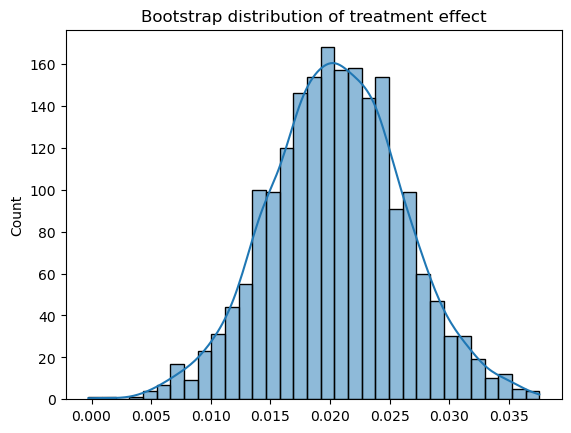

In [10]:
n_boot = 2000
diffs = []
for i in range(n_boot):
    sample = df.sample(frac=1, replace=True)
    pA = sample.loc[sample.group=='A', 'converted'].mean()
    pB = sample.loc[sample.group=='B', 'converted'].mean()
    diffs.append(pB - pA)

ci = np.percentile(diffs, [2.5, 97.5])
print(f"Bootstrap 95% CI: {ci}")
sns.histplot(diffs, kde=True)
plt.title('Bootstrap distribution of treatment effect')
plt.show()


# Conduct a bootstrap for confidence intervals

In [15]:
from statsmodels.stats.power import NormalIndPower
# Parameters
alpha = 0.05
power = 0.8
p1 = 0.08
p2 = 0.092

effect_size = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))
analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
print(f"Required sample size per group: {np.ceil(required_n)}")


Required sample size per group: 8559.0


# Compute power & minimum detectable effect (MDE)

| Metric               | Value                                 |
| -------------------- | ------------------------------------- |
| Control conversion   | 8.0%                                  |
| Treatment conversion | 9.2%                                  |
| Lift                 | +1.2 percentage points                |
| p-value              | 0.02                                  |
| 95% CI               | [0.002, 0.022]                        |
| Conclusion           | Statistically significant improvement |
